In [1]:
# 导入实验所需的相关库函数
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

# 下载实验所需的MNIST数据集
train_dataset = MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

D:\product_app\py_venvs\work_internship\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'D:\product_app\py_venvs\work_internship\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# 查看mnist数据
print(train_dataset)

# 查看是否支持cuda GPU训练
print(torch.cuda.is_available())

# 数据集切分
batch_size = 128
dataIter = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
False


In [34]:
# L2 Loss
input = torch.randn(10, 10, requires_grad=True)
target = torch.randn(10, 10)
mse_loss = torch.nn.MSELoss()
output = mse_loss(input, target)
# print("input: ", input)
print("target: ", target)
print("output: ", output)

# Cross-Entropy
input = torch.randn(10, 10, requires_grad=True)
# target = torch.empty(10, dtype=torch.long).random_(10)
cross_entropy_loss = torch.nn.CrossEntropyLoss()
output = cross_entropy_loss(input, target)
# print("input: ", input)
print("target: ", target)
print("output: ", output)

target:  tensor([[-0.1998, -1.1894, -1.6433,  0.1937, -1.0620,  0.0395,  0.7436,  0.9047,
         -0.1781,  1.6867],
        [ 1.3077,  1.9259, -0.3012,  1.4431, -0.2490,  0.1938, -0.0306,  0.6512,
         -1.1043, -2.3696],
        [-0.4523, -0.2658, -0.5239, -0.2244, -0.7385, -0.2531,  0.5238,  1.1112,
          0.4538,  1.9443],
        [-0.0584, -0.2676, -2.0967, -2.2071, -0.0657,  0.7517, -0.1296,  0.6153,
          1.0413,  0.4086],
        [ 0.0869, -0.4978, -1.0594, -1.4735, -0.2515,  1.0189, -0.8620,  0.5514,
         -0.9014, -0.5003],
        [-1.5100,  0.3660,  0.9752, -1.2986,  0.8929,  1.0936, -0.6397, -0.8358,
         -2.2101,  0.9073],
        [-0.7157, -1.2312, -0.4154,  0.3490, -0.0813, -1.3293,  0.2192, -0.9309,
          0.3177,  0.8054],
        [ 0.5167,  0.3017,  0.8533,  0.1405,  1.2427,  0.1128, -0.4405, -0.3787,
         -0.1177,  1.0497],
        [-0.1952, -0.0299,  1.1549,  2.1062,  0.4054, -1.0394, -0.7957,  0.8653,
          0.1167, -0.7736],
        [-

In [35]:
# 展平
def flatten(x):
    N = x.shape[0]  # read in N, C, H, W
    return x.view(N, -1)  # torch.Size([128, 784])


def vae_loss(x, gen_x, mean, log_var):
    # 重构项损失
    mse_loss = torch.nn.MSELoss()
    loss = mse_loss(x, gen_x)
    # 最小化 q(z|x)  和 p(z) 的距离
    KL_loss = 0.5 * torch.sum(torch.exp(log_var) + torch.pow(mean, 2) - log_var - 1)
    # print("loss_1:", loss.item(), "loss_2:", KL_loss.item())
    return loss + KL_loss

In [44]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self,
                 image_shape=(1, 28, 28),
                 dense_size=(784, 64),
                 z_dim=20):

        super(VariationalAutoEncoder, self).__init__()

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        # encoder全连接层
        self.enDense = []
        for index in range(len(dense_size) - 1):
            self.enDense.append(nn.Linear(dense_size[index], dense_size[index + 1]))

        # 隐变量层
        self.latent_mean = nn.Linear(dense_size[-1], z_dim)
        self.latent_log_var = nn.Linear(dense_size[-1], z_dim)

        # decoder全连接层
        self.deDense = []
        self.deDense.append(nn.Linear(z_dim, dense_size[-1]))
        for index in range(len(dense_size) - 1, 0, -1):
            self.deDense.append(nn.Linear(dense_size[index], dense_size[index - 1]))

        # decoder reshape
        self.dec_reshape = transforms.Lambda(
            lambda x: torch.reshape(x, (x.shape[0], 1, int(image_shape[1]), int(image_shape[2]))))

    # 编码
    def encode(self, x):
        # 展平
        out = flatten(x)
        # 全连接层
        for dense in self.enDense:
            out = dense(out)

        # 均值 mean
        latent_mean = self.latent_mean(out)
        # log方差 log_var
        latent_log_var = torch.clip(self.latent_log_var(out), -20, 2)

        return latent_mean, latent_log_var

    # 重参数化生成隐变量
    def re_parameterize(self, mu, log_var):
        var = torch.exp(log_var)
        dist = torch.distributions.Independent(torch.distributions.Normal(loc=mu, scale=var), 1)
        return dist.sample()
        # epsilon = torch.randn_like(var)
        # return mu + torch.mul(var, epsilon)

    # 解码
    def decode(self, z):
        # 全连接层
        out = self.deDense[0](z)
        for dense in self.deDense[1:]:
            out = dense(out)

        out = self.sigmoid(out)
        out = self.dec_reshape(out)

        return out

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        latent_mean, latent_log_var = self.encode(x)
        sampled_Z = self.re_parameterize(latent_mean, latent_log_var)
        Gen_X = self.decode(sampled_Z)
        return latent_mean, latent_log_var, Gen_X

In [45]:
model = VariationalAutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]           1,300
            Linear-2                   [-1, 20]           1,300
           Sigmoid-3                  [-1, 784]               0
Total params: 2,600
Trainable params: 2,600
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [46]:
# 训练模型参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备
learning_rate = 10e-2  # 学习率
epoches = 10  # 迭代20次

# 实例化模型
model = VariationalAutoEncoder().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 模型训练
train_loss = []  # 保存每个epoch的训练误差
number = len(dataIter.dataset)

In [47]:
for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        # 前向传播
        mean, log_var, gen_x = model(x)

        # 计算损失函数
        loss = vae_loss(x, gen_x, mean, log_var)
        batch_loss.append(loss.item())

        # 反向传播和优化
        optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度下降

        # 输出batch信息
        if i % 50 == 0 and i > 0:
            print("epoch : {0} | batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / x.shape[0]))

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | batch : 50 | batch average loss: 0.027408115565776825
epoch : 0 | batch : 100 | batch average loss: 0.0025337538681924343
epoch : 0 | batch : 150 | batch average loss: 0.001931218896061182
epoch : 0 | batch : 200 | batch average loss: 0.0018749559530988336
epoch : 0 | batch : 250 | batch average loss: 0.0018667582189664245
epoch : 0 | batch : 300 | batch average loss: 0.0018640096532180905
epoch : 0 | batch : 350 | batch average loss: 0.0018536323914304376
epoch : 0 | batch : 400 | batch average loss: 0.0018603454809635878
epoch : 0 | batch : 450 | batch average loss: 0.0018549521919339895
epoch[0/10] | loss:0.06185925432443619
epoch : 1 | batch : 50 | batch average loss: 0.0018641500500962138
epoch : 1 | batch : 100 | batch average loss: 0.0018585730576887727
epoch : 1 | batch : 150 | batch average loss: 0.0018588844686746597
epoch : 1 | batch : 200 | batch average loss: 0.0018573857378214598
epoch : 1 | batch : 250 | batch average loss: 0.0018545098137110472
epoch : 1 | b

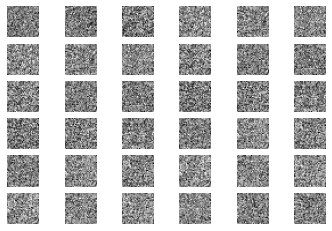

In [48]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_size, 20)).to(device)
logits = model.decode(z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy() * 255.
# 展示图片
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_hat[i * 3 + j], cmap='gray')
plt.show()